In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import glob
import time
from collections import deque
from moviepy.editor import VideoFileClip
from helperfunctions import *
from svmclassifier import *
%matplotlib inline
print('Loaded')

Loaded


In [2]:
def bin_spatial(img, size=(32, 32)):
    #print('shape of image is: ' + str(np.shape(img)))
    #print('spatial size is: ' + str(spatial_size))
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    #if img.dtype == 'float32':
    #    img = convert_png_2_jpg(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
            #print('Changed to YCrBc')
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    global spatial_features,hog_features,hist_features
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            # Combine the various features to one array
            stacked_features = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            #print('mean test_features before is ' + str(np.mean(stacked_features)))


            

            # Scale features and make a prediction
            test_features = X_scaler.transform(stacked_features)    
            #print('mean test_features scaled is ' + str(np.mean(test_features)))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            #test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles
    
print('...')

# Define a function to extract features from a list of image locations
# This function could also be used to call bin_spatial() and color_hist() (as in the lessons) to extract
# flattened spatial color features and color histogram features and combine them all (making use of StandardScaler)
# to be used together for classification
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'Lab':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
        else: feature_image = np.copy(image)      

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
        # Apply color_hist()  
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)    
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
        # Add HOG third    
        file_features.append(hog_features)
        # Add all three features to list of all images
        features.append(np.concatenate(file_features))
        
    # Return list of feature vectors
    return features

print('...')

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

print('...')

# Function courtesy of TMresolution0115
def pickle_extracted_features(pickle_file, cars, notcars, cspace, orient, 
                              px_per_cell,cl_per_block, hog_ch,
                              spat_size=(32,32), hist_bins=32):
    print('pickle ext cspace is ',cspace)
    # Time Start
    time1 = time.time()
    # extract each features
    car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
    # Time End
    time2 = time.time()
    print(' Seconds to extract features: ',round(time2-time1, 2))
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    global X_scaler
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    print('before scale cars ' + str(np.mean(car_features)) + 'and length ' + str(np.shape(car_features)))
    print('before scale' + str(np.mean(X)))
    print('after  ' + str(np.mean(scaled_X)))
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)),np.zeros(len(notcar_features))))
    
    # save scaler as pickled file
    pickle.dump({'X_scaler':X_scaler,'scaled_X':scaled_X,'y':y},open(pickle_file,"wb"))
    
    print("The input was: cspace = {}, orient = {},\
    pix_per_cell = {}, cell_per_block = {}".format(cspace,orient,px_per_cell,cl_per_block) )
    print("Extracted features are stored in pickled file:{}".format(pickle_file))


...
...
...


In [3]:
#pickle_image_folder('c://big/p5/vehicles')

In [4]:
# Read training data 
# Car
cars_files_png = glob.glob('C://big/p5/vehicles/**/*.png', recursive=True)
cars_files_jpg = glob.glob('C://big/p5/vehicles/**/*.jpg', recursive=True)
# Not Car
notcars_files = glob.glob('C://big/p5/non-vehicles/**/*.png', recursive=True)

# store filenames in cars,notcars
cars=[]
notcars=[]
# search through readed data 
# read every third image to split time-series of images
for n in range(len(cars_files_jpg)):
    if n % 2 == 0:
        cars.append(cars_files_jpg[n])
for n in range(len(cars_files_png)):
    if n % 2 == 0:
        cars.append(cars_files_png[n])
        
#print(cars)

# Do the same for non-car data
for n in range(len(notcars_files)):
    if n % 5 == 0:
        notcars.append(notcars_files[n])
        
print('Cars size is: ',np.shape(cars))
print('Not-Cars size is: ',np.shape(notcars))

Cars size is:  (4695,)
Not-Cars size is:  (1794,)


fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i in np.arange(32):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    #axs[i].set_title('Car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    #axs[i].set_title('Not Car', fontsize=10)
    axs[i].imshow(img)

In [5]:
folder = 'test'
(folder + '/**/*.png')

'test/**/*.png'

In [6]:
# Testing functions above - pickle_extracted_features()


# Feature extraction parameters
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
cspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32,32)
hist_bins = 16


# Extract the features, then save a pickle file
fname = 'X_scaler_scaled_X_y.p'
if os.path.isfile(fname) == False:
    print('Already Extracted, got my pickle')
    pass
else:
    pickle_extracted_features('X_scaler_scaled_X_y.p',cars,notcars,colorspace,orient,
                          pix_per_cell,cell_per_block,hog_channel,spatial_size,hist_bins)

# Test training_with_SVM()
training_with_SVM('X_scaler_scaled_X_y.p')

pickle ext cspace is  YCrCb
 Seconds to extract features:  22.8
before scale cars 3.16764707623and length (4695, 4308)
before scale3.16967260553
after  -1.07506824104e-17
The input was: cspace = YCrCb, orient = 11,    pix_per_cell = 16, cell_per_block = 2
Extracted features are stored in pickled file:X_scaler_scaled_X_y.p
15.7 Seconds to train SVC
Test Accuracy of SVC =  0.9795
Model saved as [ svc.pickle ] file
My SVC predictions: 
 [ 0.  1.  1.  0.  0.  1.  0.  0.  0.  1.]
For  10 labels: 
 [ 0.  1.  1.  0.  0.  1.  0.  0.  0.  1.]


...


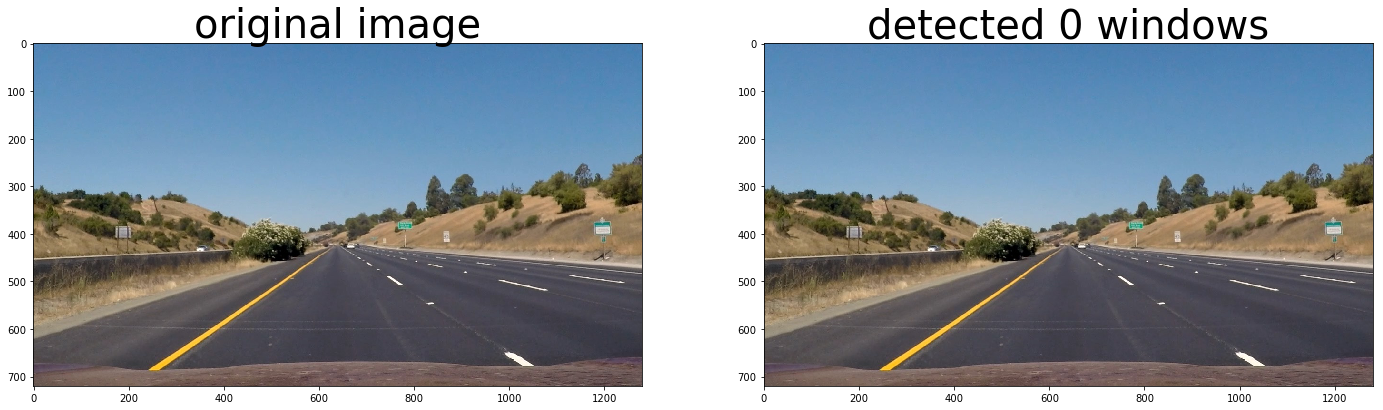

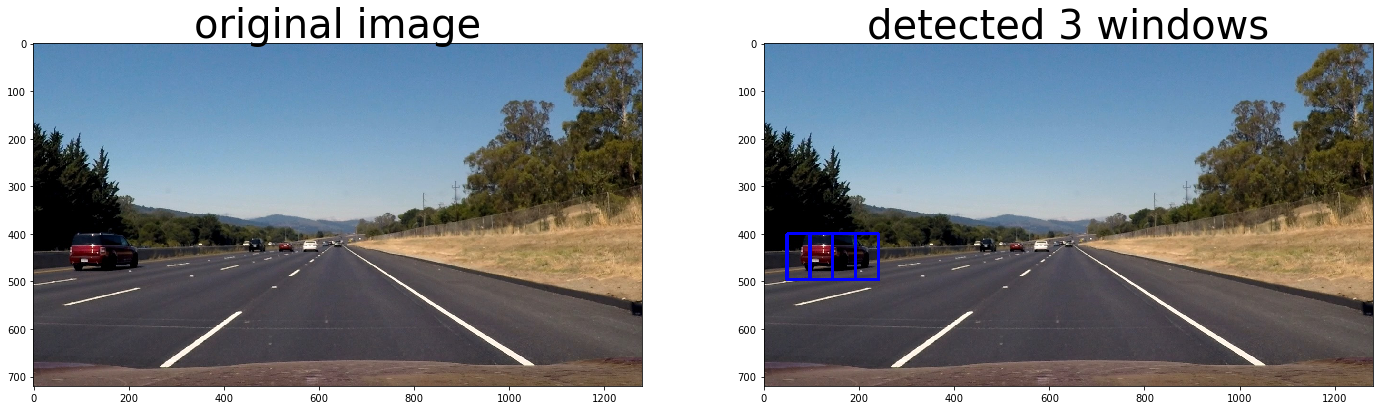

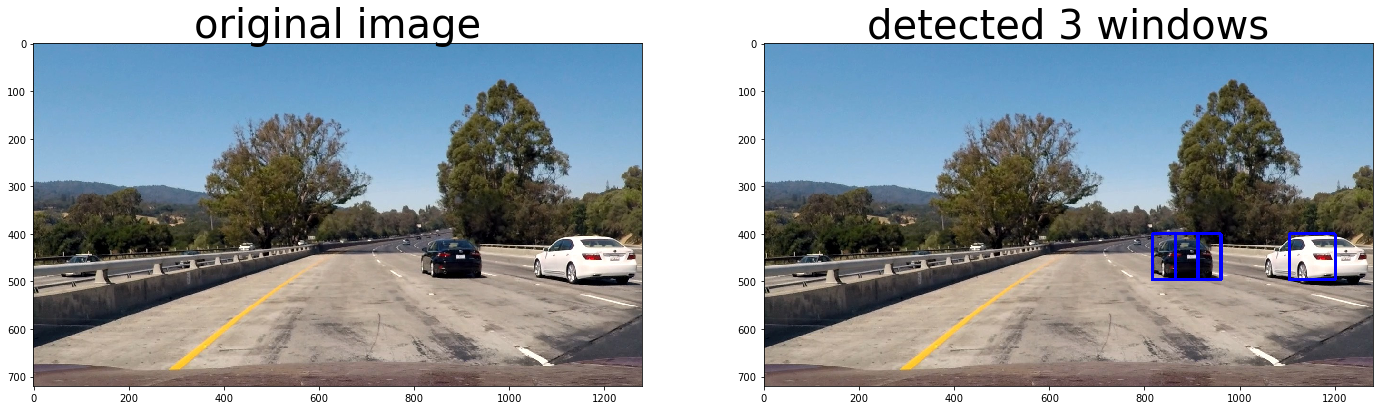

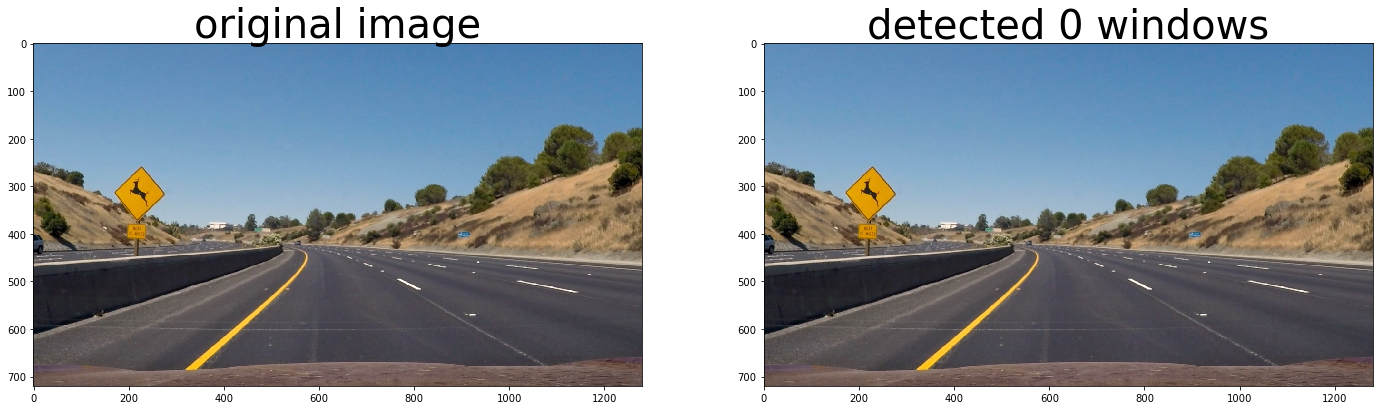

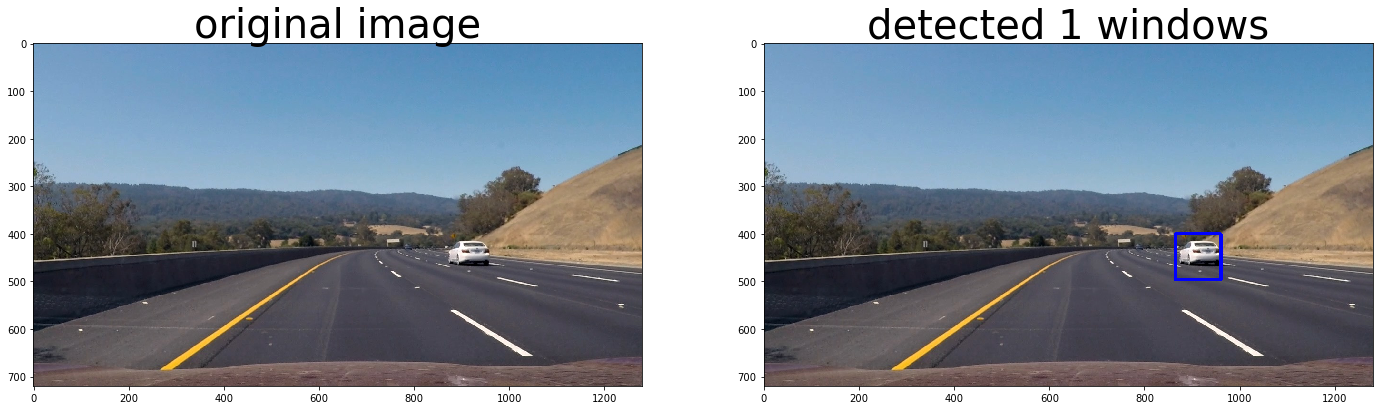

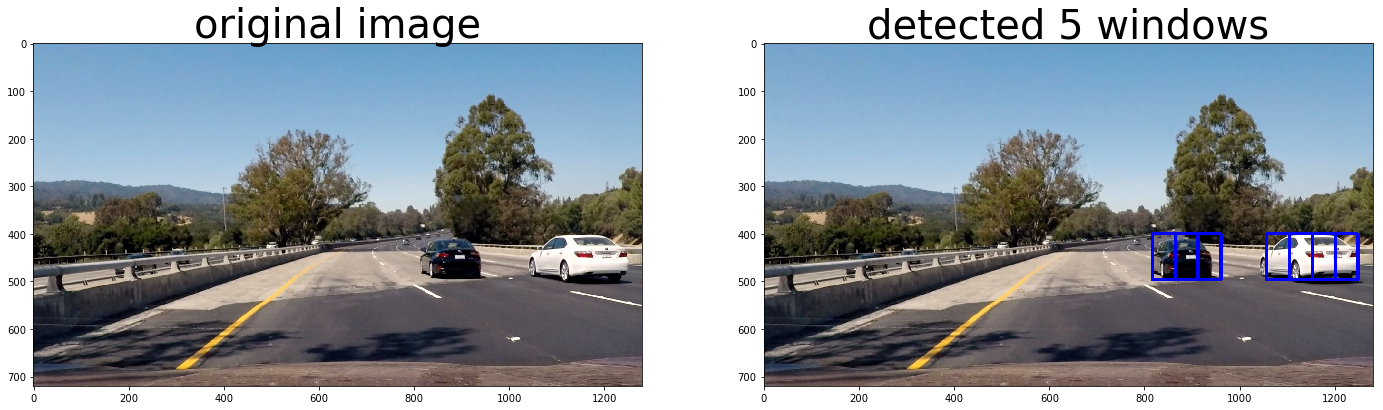

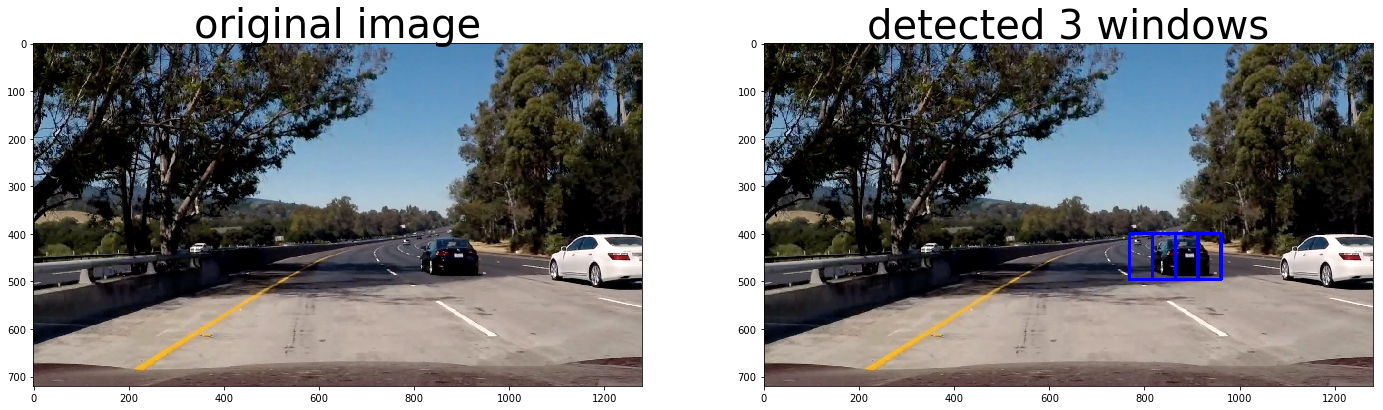

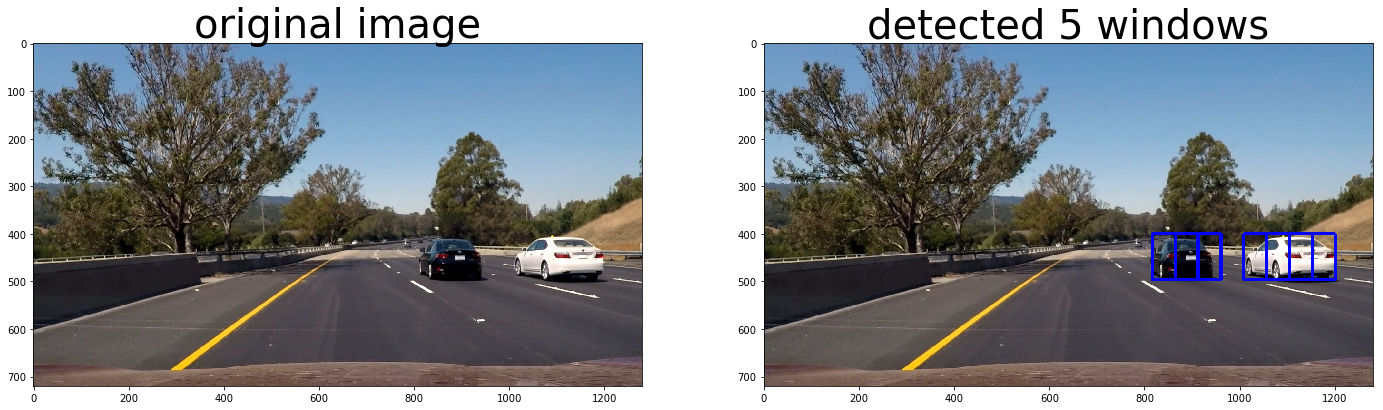

done


In [8]:
# Pull in test Image
image = mpimg.imread('media/test_images/test3.jpg')

# Load the data and trained model weights
scaled_data = pickle.load(open(fname,'rb'))
svc = pickle.load(open('svc.pickle','rb'))    
X_scaler = scaled_data["X_scaler"]

ystart = 400
ystop = 656
scale = 1.5

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

print('...')

def bin_spatial(img, size=(32,32)):
    #print('shape of image is: ' + str(np.shape(img)))
    #print('spatial size is: ' + str(size))
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

test_img = mpimg.imread('media/test_images/test1.jpg')

#rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, 
#                       svc, None, orient, pix_per_cell, cell_per_block, None, None)

input_directory = 'media/test_images/'
files = os.listdir(input_directory)
for file in files:
    filename,ext = os.path.splitext(file)
    if ext == '.jpg':
        image = mpimg.imread(input_directory + file)    

        
    rectangles = find_cars(image,ystart, ystop, scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins)

    test_img_rects = draw_boxes(image, rectangles)

        
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
    ax1.imshow(image)
    ax1.set_title('original image', fontsize=40)
    
    ax2.imshow(test_img_rects)
    ax2.set_title('detected '+ str(len(rectangles)) + ' windows', fontsize=40)
    plt.show()
print("done")
#print(win)



In [9]:
def search_with_multiscale_windows(img, cspace, orient, pix_per_cell, cell_per_block, 
                                   point_scale_data, spatial_size=(32,32), hist_bins=32):
    #print('search_with_multiscale cspace is ',cspace)
    # Define array to store recent windows
    windows = []
    origin = np.copy(img)
    svc = pickle.load(open('svc.pickle','rb'))
    
    scal_data = pickle.load(open('X_scaler_scaled_X_y.p','rb'))
    X_scaler = scal_data["X_scaler"]
    
    ystart=point_scale_data[0]
    ystop=point_scale_data[1]
    scale=point_scale_data[2]
    #print(ystart,ystop,scale)
    
    for y_start,y_end, scales in zip(ystart,ystop,scale):
        #print(ystart)
        rectangles = find_cars(img, int(ystart), int(ystop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins)
        
        #windows = windows + win_list
    
    return rectangles

# test function above - find_cars
image = mpimg.imread('media/test_images/test3.jpg')

y_half = image.shape[0] // 2
y_end = image.shape[0] #- (y_half % 64)
ystart = [y_half,y_half+100]
ystop = [y_end-100, y_end]
scale = [1.6,2.2]
ystart = [400]
ystop = [700]
scale = [1.5]
point_scale_data = np.vstack((ystart,ystop,scale))
print(point_scale_data)
windows = search_with_multiscale_windows(image, cspace, orient, pix_per_cell, cell_per_block, 
                                         point_scale_data, hist_bins=16)


print(windows)
print(len(windows))

[[ 400. ]
 [ 700. ]
 [   1.5]]
[((864, 400), (960, 496))]
1


Number of boxes:  78


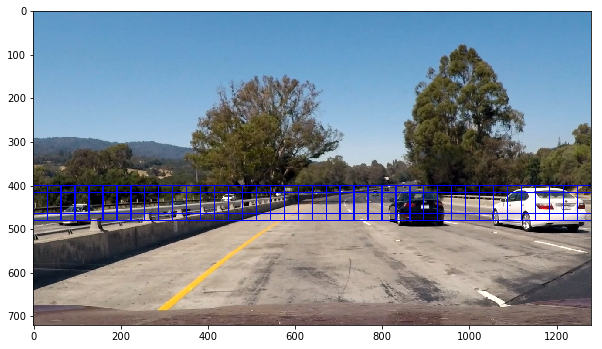

In [10]:
test_img = mpimg.imread('media/test_images/test1.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, int(ystart), int(ystop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, show_all_rectangles=True))

ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, int(ystart), int(ystop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

In [11]:
def process_frame(img):

    rects = []

    test_img = img
    #colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    #orient = 11
    #pix_per_cell = 16
    #cell_per_block = 2
    #hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    y_start = 400
    y_stop = 464
    scale = 1.0
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 416
    y_stop = 480
    scale = 1.0
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 400
    y_stop = 496
    scale = 1.5
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 432
    y_stop = 528
    scale = 1.5
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 400
    y_stop = 528
    scale = 2.0
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 432
    y_stop = 560
    scale = 2.0
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 400
    y_stop = 596
    scale = 3.5
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
    y_start = 464
    y_stop = 660
    scale = 3.5
    rects.append(find_cars(test_img, int(ystart), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

    rectangles = [item for sublist in rects for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

print('...')

...


...


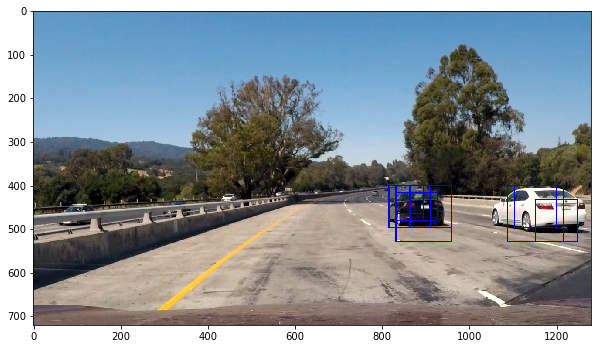

In [12]:
img = mpimg.imread('media/test_images/test1.jpg')

rects = []

#colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 11
#pix_per_cell = 16
#cell_per_block = 2
#hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


y_start = 400
y_stop = 464
scale = 1.0
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 416
y_stop = 480
scale = 1.0
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 400
y_stop = 496
scale = 1.5
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 432
y_stop = 528
scale = 1.5
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 400
y_stop = 528
scale = 2.0
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 432
y_stop = 560
scale = 2.0
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 400
y_stop = 596
scale = 3.5
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))
y_start = 464
y_stop = 660
scale = 3.5
rects.append(find_cars(test_img, int(y_start), int(y_stop), scale, colorspace, 
                       hog_channel, svc, X_scaler, orient, pix_per_cell, 
                       cell_per_block, spatial_size, hist_bins))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('...')

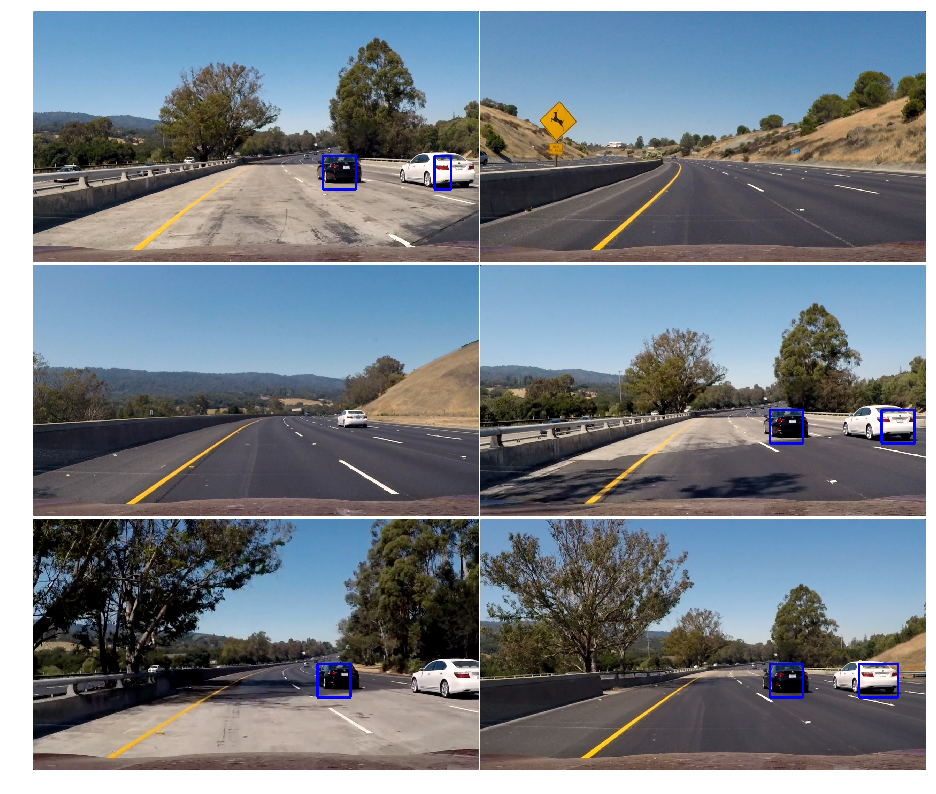

In [13]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

test_images = glob.glob('media/test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

In [14]:

iteration = 1

# keep current heatmaps
heatmaps = deque(maxlen=15)
def process_video(image):
    cimg = np.copy(image)
    windows = search_with_multiscale_windows(image, cspace, orient, pix_per_cell, cell_per_block,
                                             point_scale_data, spatial_size, hist_bins)
    

    iteration = 1
    #print("iterations: ",iteration)
    #global iteration, heatmaps
    if len(windows) > 0:
        heat = np.zeros_like(image[:,:,0]).astype(np.float)
        heat = add_heat(heat, windows)
        heatmaps.append(heat)
        #print(len(heatmaps))
        # take recent 10 heatmaps and average them
        if len(heatmaps) == 3:
            avg_heat = sum(heatmaps)/len(heatmaps)
            heat = avg_heat
        heat = apply_threshold(heat,1)
        heatmap = np.clip(heat, 0, 255)
        #heatmaps.append(heatmap)
        #if iteration % 10 == 0:
        #    heatmap = avg_heatmaps
        labels = label(heatmap)
        draw_img, rect = draw_labeled_bboxes(cimg, labels)
    else:
        # pass the image itself if nothing was detected
        draw_img = cimg
    iteration += 1
    return draw_img

# test on short video
output_name = 'testing_video_thresh_v2.mp4'
#clip0 = VideoFileClip("media/project_video.mp4")
clip0 = VideoFileClip("media/project_video.mp4").subclip(15,31)
clipping = clip0.fl_image(process_video)
%time clipping.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video testing_video_thresh_v2.mp4
[MoviePy] Writing video testing_video_thresh_v2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▊| 400/401 [03:02<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testing_video_thresh_v2.mp4 

Wall time: 3min 2s
